# Fraud detection

This notebook demonstrates using logistic regression for detecting credit card fraud using the kaggle dataset found here: https://www.kaggle.com/c/ieee-fraud-detection

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
folder_path = '.'
train_identity = pd.read_csv(f'{folder_path}/train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}/train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}/test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}/test_transaction.csv')
sub = pd.read_csv(f'{folder_path}/sample_submission.csv')

# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
# Cleanup
del train_identity, train_transaction, test_identity, test_transaction

In [6]:
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')

There are 414 columns in train dataset with missing values.


In [7]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [8]:
print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


Most of columns have missing data, which is normal in real world. Also there are columns with one unique value (or all missing). There are a lot of continuous variables and some categorical. Let's have a closer look at them.

### Data Exploration

Let's start with identity information. id_01 - id_11 are continuous variables, id_12 - id_38 are categorical and the last two columns are obviously also categorical.

Text(0.5,1,'Distribution of id_01 variable')

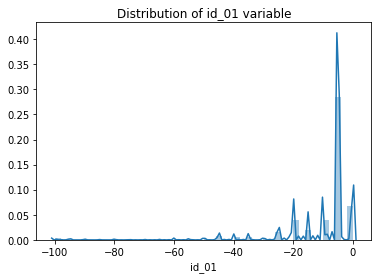

In [9]:
g = sns.distplot(train['id_01'].dropna())
g.set_title('Distribution of id_01 variable')

`id_01` has an interesting distribution: it has 77 unique non-positive values with skeweness to 0.

In [10]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN     0.887689
 0.0    0.108211
 1.0    0.001461
 3.0    0.001131
 2.0    0.000713
Name: id_03, dtype: float64

`id_03` has 88% of missing values and 98% of values are either missing or equal to 0.

In [11]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

NaN            0.761273
 100.000000    0.225492
 95.080002     0.002085
 95.160004     0.001277
 97.120003     0.000745
Name: id_11, dtype: float64

22% of values in `id_11` are equal to 100 and 76% are missing. Quite strange.

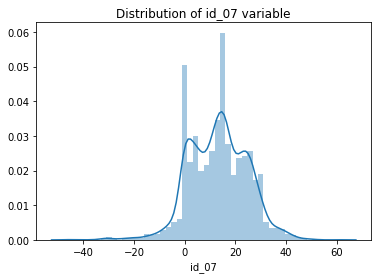

In [12]:
g = sns.distplot(train['id_07'].dropna());
g.set_title('Distribution of id_07 variable');

Some of features seem to be normalized. So if someone wants to normalize all variables, it would be necessary to separate such variables which seem to be already normalized.

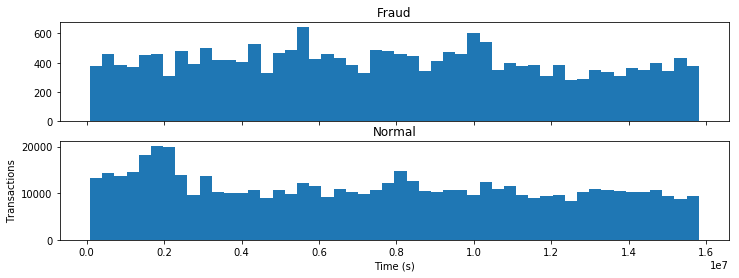

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(train.TransactionDT[train.isFraud == 1], bins = 50)
ax1.set_title('Fraud')
ax2.hist(train.TransactionDT[train.isFraud == 0], bins = 50)
ax2.set_title('Normal')
plt.xlabel('Time (s)')
plt.ylabel('Transactions')
plt.show()

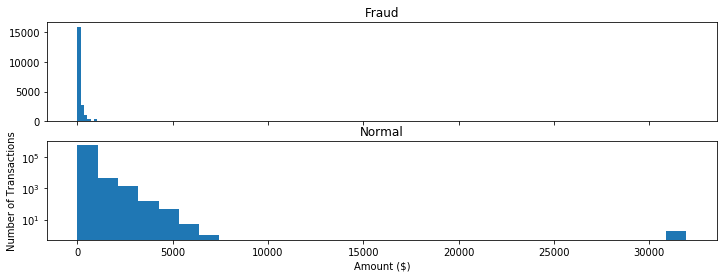

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(train.TransactionAmt[train.isFraud == 1], bins = 30)
ax1.set_title('Fraud')
ax2.hist(train.TransactionAmt[train.isFraud == 0], bins = 30)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

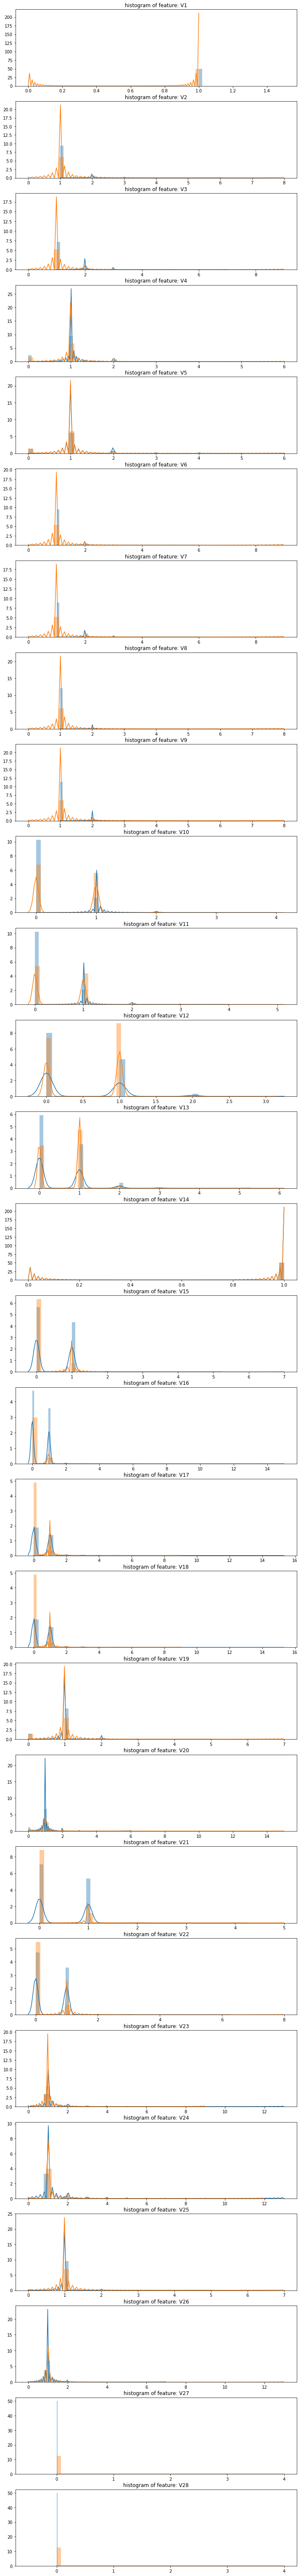

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i in range(1, 29):
    ax = plt.subplot(gs[i-1])
    sns.distplot(train['V'+str(i)][train.isFraud == 1].dropna())
    sns.distplot(train['V'+str(i)][train.isFraud == 0].dropna())
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + 'V'+str(i))
    
plt.show()
plt.tight_layout()

### Prepare dataset

In [16]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [17]:
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [18]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

82

In [19]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [20]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [21]:
#Create dataframes of only Fraud and Normal transactions. Also Shuffle them.
fraud = shuffle(train[train.isFraud == 1])
normal = shuffle(train[train.isFraud == 0])

# Produce a training set of 80% of fraudulent and 80% normal transactions
X_train = fraud.sample(frac=0.8)
X_train = pd.concat([X_train, normal.sample(frac = 0.8)], axis = 0)

# Split remainder into testing and validation
remainder = train.loc[~train.index.isin(X_train.index)]
X_test = remainder.sample(frac=0.7)
X_validate = remainder.loc[~remainder.index.isin(X_test.index)]

In [22]:
# Shuffle the datasets once more to ensure random feeding into the classification algorithms
X_train = shuffle(X_train)
X_test = shuffle(X_test)
X_validate = shuffle(X_validate)
X_train_ = shuffle(X_train) #_resampled)
X_test_ = shuffle(X_test)
X_validate_ = shuffle(X_validate)
data_resampled = pd.concat([X_train_, X_test_, X_validate_])

In [23]:
y_train = X_train.sort_values('TransactionDT')['isFraud'].replace(np.nan, 0)
X_train = X_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)

y_test = X_test.sort_values('TransactionDT')['isFraud'].replace(np.nan, 0)
X_test = X_test.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)

y_validate = X_validate.sort_values('TransactionDT')['isFraud'].replace(np.nan, 0)
X_validate = X_validate.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)

#X_test = X_test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train
#test = test[["TransactionDT", 'TransactionID']]

In [24]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf, np.nan], 0)   

# Cleaning infinite values to NaN
X_train = clean_inf_nan(X_train)
X_test = clean_inf_nan(X_test)
X_validate = clean_inf_nan(X_validate)
test = clean_inf_nan(test)

### Training and running predictions on the model

In [25]:
# Create and train the model on the training data
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
# Run the following to test your model, tuning the hyperparameters
model.score(X_test, y_test)

0.9657820891189705

In [27]:
# Finally, run the following to validate that your model is achieving the expected performance without overfitting
model.score(X_validate, y_validate)

0.9650880559945811